In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

## Preprocessing

In [2]:
path = '/Users/noahraegrant/workspace/github.com/nohrg/DS5220/Final Project/MURA-v1.1'

#train
train_images = pd.DataFrame(pd.read_csv(path + '/train_image_paths.csv', header = None, names =['image_path']))
train_studies = pd.DataFrame(pd.read_csv(path + '/train_labeled_studies.csv', header= None, names=['study_path', 'label']))

#validation
val_images = pd.DataFrame(pd.read_csv(path + '/valid_image_paths.csv', header = None, names =['image_path']))
val_studies = pd.DataFrame(pd.read_csv(path + '/valid_labeled_studies.csv', header= None, names=['study_path', 'label']))

In [3]:
train_images['study_label'] = train_images['image_path'].str.rsplit('/', n=2, expand=True)[1].str.rsplit('_', n=1, expand=True)[1]

val_images['study_label'] = val_images['image_path'].str.rsplit('/', n=2, expand=True)[1].str.rsplit('_', n=1, expand=True)[1]
train_images['label'] = train_images['study_label'].map({'positive': 1, 'negative': 0})

val_images['label'] = val_images['study_label'].map({'positive': 1, 'negative': 0})
train_images['XR'] = train_images['image_path'].str.rsplit('/', n=5, expand=True)[2]
val_images['XR'] = val_images['image_path'].str.rsplit('/', n=5, expand=True)[2]

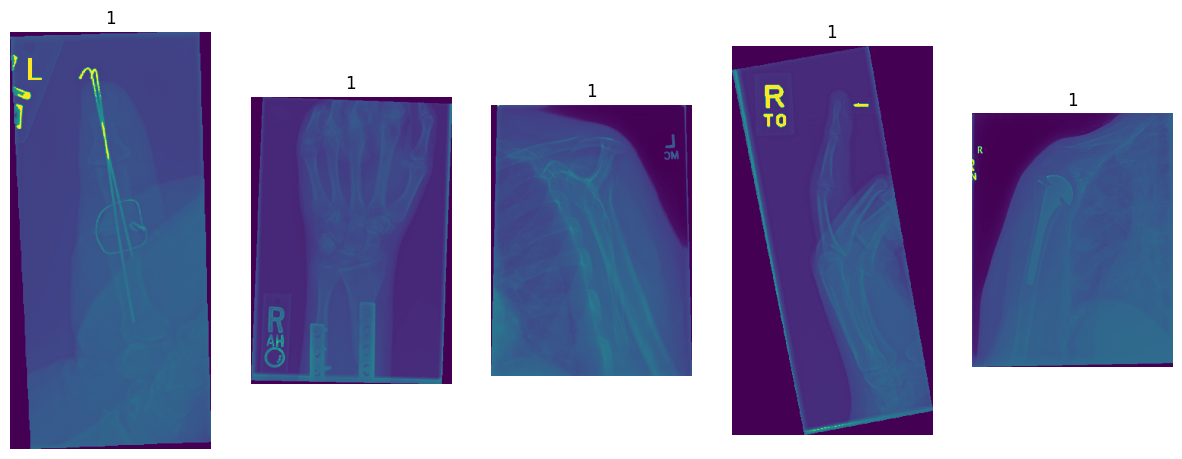

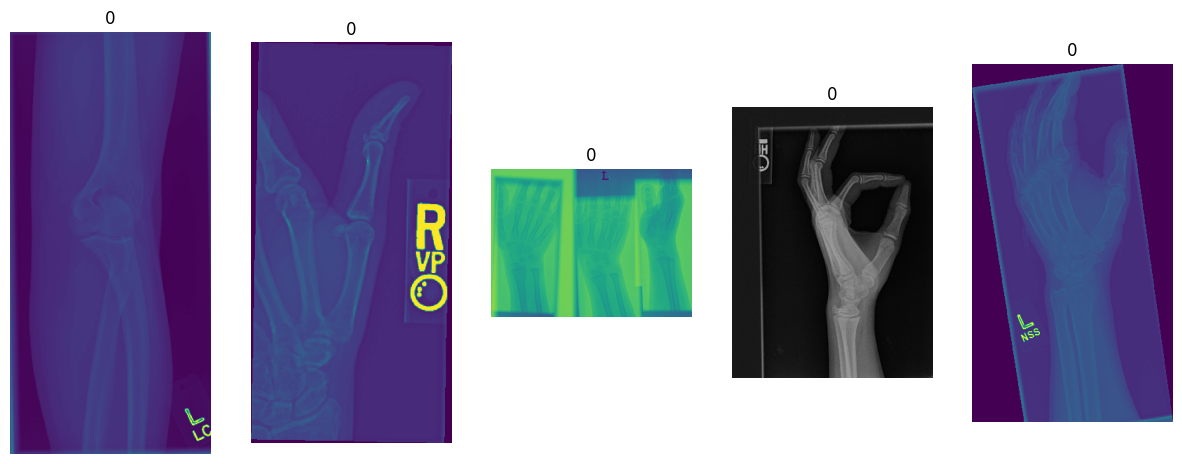

In [4]:
import matplotlib.pyplot as plt
import random
from PIL import Image

prefix = "/Users/noahraegrant/workspace/github.com/nohrg/DS5220/Final Project/"

def plot_random_images(df, label, n=5):
    images = df[df['label'] == label]['image_path'].sample(n)
    plt.figure(figsize=(15, 15))
    for i, path in enumerate(images):
        img = Image.open(prefix + path)
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    plt.show()

# Show samples for each class
for label in train_images['label'].unique():
    plot_random_images(train_images, label)

In [5]:
categories = set(train_images['XR'].values)
categories

{'XR_ELBOW',
 'XR_FINGER',
 'XR_FOREARM',
 'XR_HAND',
 'XR_HUMERUS',
 'XR_SHOULDER',
 'XR_WRIST'}

## Training

In [6]:
prefix = '/Users/noahraegrant/workspace/github.com/nohrg/DS5220/Final Project/'
train_images['image_path'] = prefix + train_images['image_path']
val_images['image_path'] = prefix + val_images['image_path']


In [7]:
def subcategorize_data (training:pd.DataFrame, testing:pd.DataFrame, category:str) -> tuple[pd.DataFrame, pd.DataFrame]:
    train = training[training['XR'] == category]
    test = testing[testing['XR'] == category]
    return train, test

elbow_train, elbow_test = subcategorize_data(train_images, val_images, 'XR_ELBOW')
finger_train, finger_test = subcategorize_data(train_images, val_images, 'XR_FINGER')
forearm_train, forearm_test = subcategorize_data(train_images, val_images, 'XR_FOREARM')
hand_train, hand_test = subcategorize_data(train_images, val_images, 'XR_HAND')
humerus_train, humerus_test = subcategorize_data(train_images, val_images, 'XR_HUMERUS')
shoulder_train, shoulder_test = subcategorize_data(train_images, val_images, 'XR_SHOULDER')
wrist_train, wrist_test = subcategorize_data(train_images, val_images, 'XR_WRIST')

In [8]:
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 pixels
    transforms.ToTensor(),  # Convert to tensor
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize (for pre-trained models)
])

# Custom Dataset class to handle loading and transformations
class ImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        label = self.df.iloc[idx]['label']

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label

In [9]:
def create_dataloader(images:pd.DataFrame, transformer:transforms.Compose, batch_size:int):
    dataset = ImageDataset(images, transform=transformer)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

In [ ]:
batch_size = 8
elbow_loader = create_dataloader(elbow_train, transform, batch_size)
elbow_test_loader = create_dataloader(elbow_test, transform, batch_size)

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class Specialized_CNN(nn.Module):
    def __init__(self, num_classes):
        super(Specialized_CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        self.batch = nn.BatchNorm2d(64)
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        self.fc = nn.Sequential(
            nn.Linear(128*56*56, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features = 64, out_features= num_classes)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.batch(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [36]:
num_classes = 2
model = Specialized_CNN(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Specialized_CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (batch): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=401408, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [ ]:
def train_model(model, dataloader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Accumulate the loss
            running_loss += loss.item()

        # Print loss per epoch
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(dataloader):.4f}")
    print("Training complete")

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # No need to calculate gradients during evaluation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")

In [39]:
train_model(model, elbow_loader, criterion, optimizer, num_epochs=10)

Epoch [1/10], Loss: 1.3412
Epoch [2/10], Loss: 0.6813
Epoch [3/10], Loss: 0.6776
Epoch [4/10], Loss: 0.6761
Epoch [5/10], Loss: 0.6751
Epoch [6/10], Loss: 0.6749
Epoch [7/10], Loss: 0.6763
Epoch [8/10], Loss: 0.6763
Epoch [9/10], Loss: 0.6748
Epoch [10/10], Loss: 0.6763
Training complete


In [40]:
evaluate_model(model, elbow_test_loader)

Accuracy: 50.54%


Notes for self:
- humerus
- look up more conv network designs/numbers? it might not like powers of 2

In [ ]:
class Specialized_CNN_2(nn.Module):
    def __init__(self, num_classes):
        super(Specialized_CNN_2, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        self.batch1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        self.batch2 = nn.BatchNorm2d(256)
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        )
        self.batch3 = nn.BatchNorm2d(1024)
        self.fc = nn.Sequential(
            nn.Linear(1024*56*56, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features = 64, out_features= num_classes)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.conv3(x)
        x = self.batch3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [60]:
num_classes = 2
humerus_model = Specialized_CNN_2(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(humerus_model.parameters(), lr=0.001, momentum=0.9)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
humerus_model.to(device)

Specialized_CNN_2(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel

In [57]:
humerus_loader = create_dataloader(humerus_train, transform, 32)
humerus_test_loader = create_dataloader(humerus_test, transform, 32)

In [34]:
train_model(humerus_model, humerus_loader, criterion, optimizer, num_epochs=10)

Epoch [1/10], Loss: 1.7118
Epoch [2/10], Loss: 0.6913
Epoch [3/10], Loss: 0.7041
Epoch [4/10], Loss: 0.6978
Epoch [5/10], Loss: 0.6958
Epoch [6/10], Loss: 0.6941
Epoch [7/10], Loss: 0.6937
Epoch [8/10], Loss: 0.6924
Epoch [9/10], Loss: 0.6925
Epoch [10/10], Loss: 0.6923
Training complete


In [35]:
evaluate_model(humerus_model, humerus_test_loader)

Accuracy: 51.39%


In [51]:
def train_one_epoch(model, epoch_index, tb_writer, training_loader, criterion):
    model.train()
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = criterion(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [52]:
num_classes = 2
humerus_model = Specialized_CNN_2(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(humerus_model.parameters(), lr=0.01)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
humerus_model.to(device)

Specialized_CNN_2(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class Specialized_CNN_3(nn.Module):
    def __init__(self):
        super(Specialized_CNN_3, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        self.batch1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        self.batch2 = nn.BatchNorm2d(256) 
        self.fc = nn.Sequential(
            nn.Linear(in_features = 256*56*56, out_features = 16),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features = 16, out_features= 1)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.conv2(x)
        x = self.batch2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [13]:
batch_size = 8
elbow_loader = create_dataloader(elbow_train, transform, batch_size)
elbow_test_loader = create_dataloader(elbow_test, transform, batch_size)

humerus_loader = create_dataloader(humerus_train, transform, batch_size)
humerus_test_loader = create_dataloader(humerus_test, transform, batch_size)

finger_loader = create_dataloader(finger_train, transform, batch_size)
finger_test_loader = create_dataloader(finger_test, transform, batch_size)

forearm_loader = create_dataloader(forearm_train, transform, batch_size)
forearm_test_loader = create_dataloader(forearm_test, transform, batch_size)

hand_loader = create_dataloader(hand_train, transform, batch_size)
hand_test_loader = create_dataloader(hand_test, transform, batch_size)

shoulder_loader = create_dataloader(shoulder_train, transform, batch_size)
shoulder_test_loader = create_dataloader(shoulder_test, transform, batch_size)

wrist_loader = create_dataloader(wrist_train, transform, batch_size)
wrist_test_loader = create_dataloader(wrist_test, transform, batch_size)


In [14]:
import time
import numpy as np
from sklearn.metrics import accuracy_score
def train_model(model, train_dataloader,val_dataloader, criterion, optimizer, num_epochs=10):
    # Xin's implementation of train_model
    train_loss, train_acc, val_loss, val_acc = [], [], [], []
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()  # Set the model to training mode
        running_loss = 0.0
        preds, labels = [], []
        for images, label in iter(train_dataloader):
            images, label = images.to(device), label.to(device).float()
            
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images).squeeze(1)
           
            loss = criterion(outputs, label)
            # Accumulate the loss
            running_loss += loss.item()
      

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            probabilities = torch.sigmoid(outputs)
            pred = (probabilities > 0.5).long() 
            preds.append(pred.detach().cpu().numpy())     
            labels.append(label.detach().cpu().numpy())
             
        # train_acc    
        preds = np.hstack(preds)
        labels = np.hstack(labels)
        train_acc.append(accuracy_score(labels, preds))
        
        # train_loss
        loss = running_loss / len(train_dataloader)
        
        train_loss.append(loss)
        
        # Perform validation
        model.eval()
        with torch.no_grad():
            preds, targets = [], []
            running_loss = 0
            for images, label in iter(val_dataloader):
                images, label = images.to(device), label.to(device).float()

                outputs = model(images).squeeze(1)

                loss = criterion(outputs, label)
                running_loss += loss.item()

                # Calculate val_acc
                probabilities = torch.sigmoid(outputs)
                pred = (probabilities > 0.5).long()  # For binary classification
                preds.append(pred.detach().cpu().numpy())
                targets.append(label.detach().cpu().numpy())
        
            preds = np.hstack(preds)
            targets = np.hstack(targets)
        
            val_acc.append(accuracy_score(targets, preds))
            val_loss.append(running_loss / len(val_dataloader))

        spent_time = time.time() - start_time

        print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_loss[-1]:.4f}, Validation Loss: {val_loss[-1]:.4f}. Spent {spent_time:.4f}s.")
        
    print("Training complete.")
    return train_loss, train_acc, val_loss, val_acc


In [34]:
model = Specialized_CNN_3()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Specialized_CNN_3(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (batch2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Sequential(
    (0): Linear(in_features=802816, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [35]:
num_epochs = 10
elbow_train_loss, elbow_train_acc, elbow_val_loss, elbow_val_acc = train_model(model, elbow_loader, elbow_test_loader, criterion, optimizer, num_epochs)

Epoch [1/10], Training Loss: 1.7247, Validation Loss: 0.7287. Spent 913.3374s.
Epoch [2/10], Training Loss: 0.6800, Validation Loss: 0.7258. Spent 953.0050s.
Epoch [3/10], Training Loss: 0.6767, Validation Loss: 0.7071. Spent 989.1340s.
Epoch [4/10], Training Loss: 0.6759, Validation Loss: 0.7217. Spent 942.5120s.


KeyboardInterrupt: 